In [1]:
pip install -q git+https://github.com/tensorflow/docs

In [0]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

24576/17858 [=========================================] - 0s 0us/step


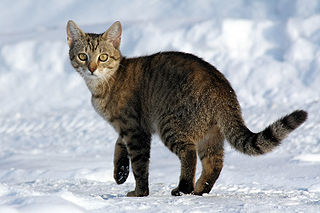

In [4]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1, 2, 1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.title('Augmented image')
  plt.imshow(augmented)
  

In [7]:
image

<tf.Tensor: shape=(213, 320, 3), dtype=uint8, numpy=
array([[[194, 206, 218],
        [194, 206, 218],
        [194, 206, 218],
        ...,
        [169, 190, 207],
        [162, 184, 205],
        [158, 180, 204]],

       [[195, 207, 219],
        [195, 207, 219],
        [195, 207, 219],
        ...,
        [170, 191, 208],
        [162, 184, 205],
        [155, 179, 203]],

       [[196, 208, 220],
        [196, 208, 220],
        [196, 208, 220],
        ...,
        [170, 191, 208],
        [161, 183, 206],
        [154, 178, 202]],

       ...,

       [[232, 237, 241],
        [234, 239, 243],
        [236, 241, 245],
        ...,
        [211, 220, 229],
        [213, 222, 229],
        [202, 211, 216]],

       [[234, 239, 242],
        [236, 241, 244],
        [238, 243, 246],
        ...,
        [217, 226, 235],
        [221, 230, 235],
        [212, 221, 226]],

       [[235, 240, 243],
        [237, 242, 245],
        [239, 244, 247],
        ...,
        [221, 230, 23

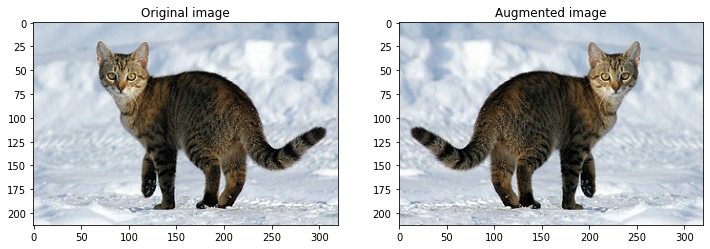

In [8]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

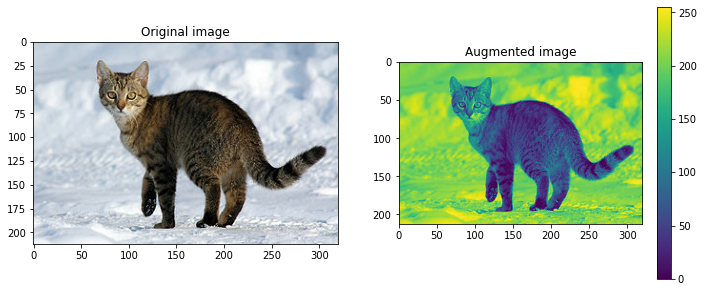

In [9]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

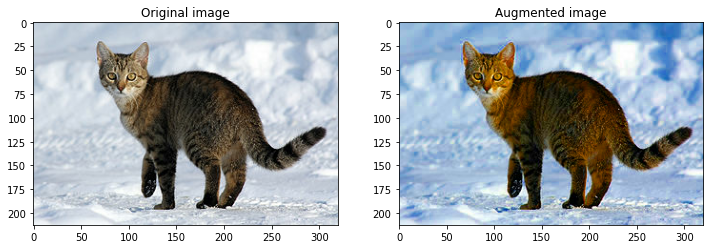

In [10]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

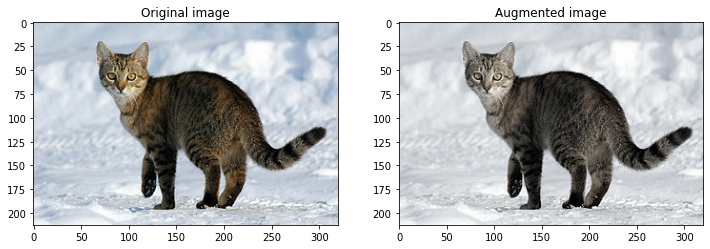

In [11]:
bright = tf.image.adjust_saturation(image, 0.4)
visualize(image, bright)

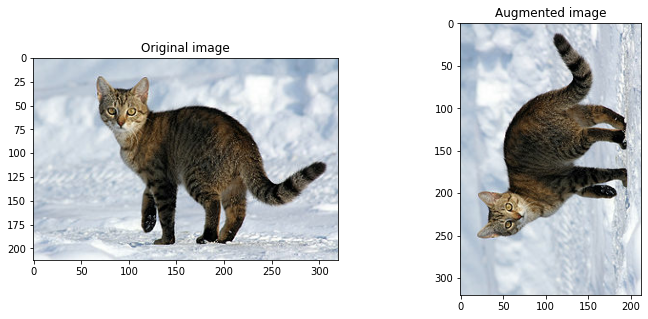

In [12]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

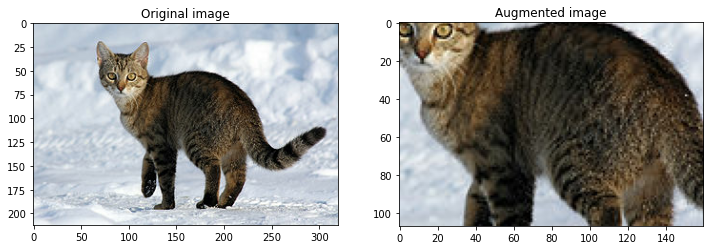

In [13]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

In [14]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [0]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [0]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [0]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [0]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [0]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [21]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 16s 516ms/step - loss: 0.7616 - accuracy: 0.7671 - val_loss: 0.3806 - val_accuracy: 0.8849
Epoch 2/50
32/32 [==============================] - 16s 509ms/step - loss: 0.1801 - accuracy: 0.9429 - val_loss: 0.3004 - val_accuracy: 0.9120
Epoch 3/50
32/32 [==============================] - 16s 504ms/step - loss: 0.0896 - accuracy: 0.9702 - val_loss: 0.2918 - val_accuracy: 0.9213
Epoch 4/50
32/32 [==============================] - 16s 505ms/step - loss: 0.0522 - accuracy: 0.9844 - val_loss: 0.3436 - val_accuracy: 0.9185
Epoch 5/50
32/32 [==============================] - 16s 508ms/step - loss: 0.0397 - accuracy: 0.9883 - val_loss: 0.3687 - val_accuracy: 0.9158
Epoch 6/50
32/32 [==============================] - 16s 509ms/step - loss: 0.0356 - accuracy: 0.9888 - val_loss: 0.3303 - val_accuracy: 0.9195
Epoch 7/50
32/32 [==============================] - 16s 509ms/step - loss: 0.0121 - accuracy: 0.9976 - val_loss: 0.2826 - val_accuracy: 0.9348

In [0]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)